# Project 1: Principal Component Analysis and Eigenfaces

**Author:** Miguel Planas Díaz (Erasmus+ Student)  
**Personal Code:** 11071870  
**Matricola:** 276442

---

## Overview

This notebook explores **Principal Component Analysis (PCA)** applied to facial recognition through the computation of **Eigenfaces**. We will:

1. Load and preprocess the faces dataset
2. Compute the normalized data matrix
3. Perform PCA using Singular Value Decomposition (SVD)
4. Visualize the first 25 eigenfaces
5. Reduce dimensionality from 1024 to 100
6. Reconstruct images and analyze reconstruction error

---

## Learning Objectives

- Understand PCA as a dimensionality reduction technique
- Learn how eigenfaces capture facial features
- Analyze the trade-off between compression and reconstruction quality

## 1. Setup and Imports

In [ ]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.linalg as la
from tqdm import tqdm
import sys

# Add src to path for custom modules
sys.path.insert(0, '../src')

# Custom utilities
from pca_utils import (
    normalize_data, compute_pca, get_eigenfaces,
    project_data, reconstruct_data, compute_reconstruction_error,
    explained_variance_ratio, cumulative_explained_variance
)
from visualization import (
    plot_eigenfaces, plot_image_grid, plot_reconstruction_comparison,
    plot_reconstruction_error, plot_explained_variance
)

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
np.set_printoptions(precision=4, suppress=True)

print("Setup complete!")

✅ Setup complete!


## 2. Load and Explore the Dataset

In [4]:
# Load the faces dataset
data = sio.loadmat('../data/faces.mat')
X = data['X']

print(f"Dataset shape: {X.shape}")
print(f"Number of images: {X.shape[0]}")
print(f"Pixels per image: {X.shape[1]}")
print(f"Image dimensions: {int(np.sqrt(X.shape[1]))} x {int(np.sqrt(X.shape[1]))}")
print(f"\nData range: [{X.min():.2f}, {X.max():.2f}]")
print(f"Mean pixel value: {X.mean():.2f}")

Dataset shape: (5000, 1024)
Number of images: 5000
Pixels per image: 1024
Image dimensions: 32 x 32

Data range: [-127.87, 127.13]
Mean pixel value: -0.00


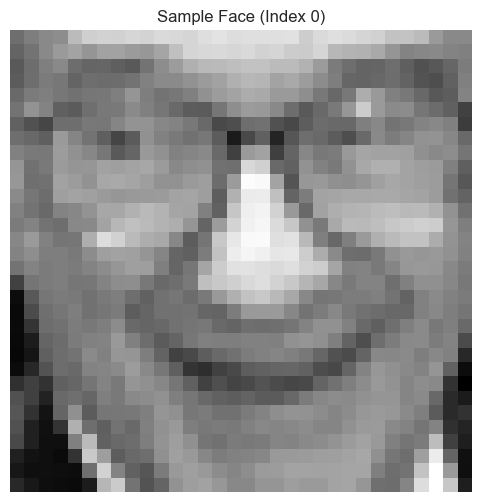

In [5]:
# Visualize a sample face
sample_idx = 0
x0 = np.transpose(np.reshape(X[sample_idx, :], (32, 32)))

plt.figure(figsize=(6, 6))
plt.imshow(x0, cmap='gray')
plt.title(f'Sample Face (Index {sample_idx})')
plt.axis('off')
plt.show()

## 3. Data Normalization

Before performing PCA, we need to center the data by subtracting the mean face from each image. This is essential because PCA identifies directions of maximum variance from the origin.

$$\tilde{X} = X - \bar{X}$$

where $\bar{X}$ is the mean face vector.

In [6]:
# Compute normalized matrix
X_mean = np.mean(X, axis=0)
X_normalized = X - X_mean

print(f"Mean face shape: {X_mean.shape}")
print(f"Normalized data shape: {X_normalized.shape}")
print(f"\nOriginal mean per feature: {np.mean(X, axis=0).mean():.4f}")
print(f"Normalized mean per feature: {np.mean(X_normalized, axis=0).mean():.10f}")

Mean face shape: (1024,)
Normalized data shape: (5000, 1024)

Original mean per feature: -0.0000
Normalized mean per feature: -0.0000000000


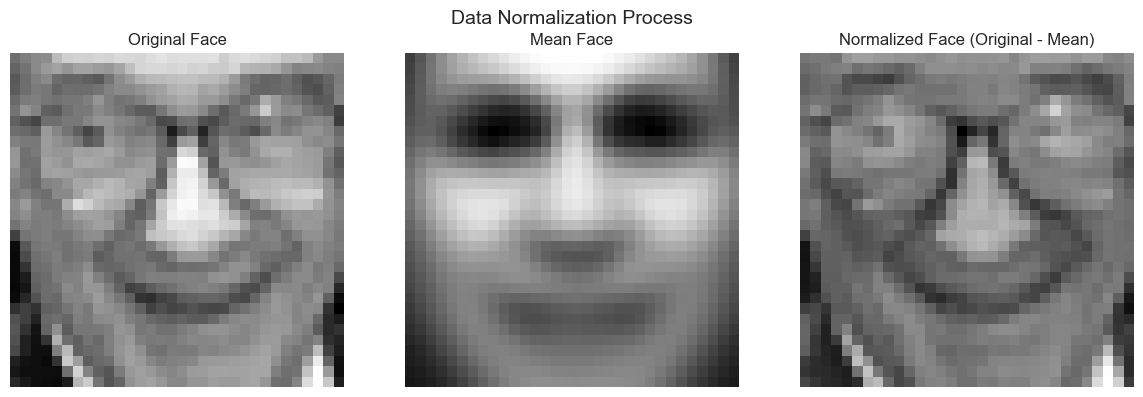

In [7]:
# Visualize the mean face
mean_face = X_mean.reshape(32, 32).T

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(X[0].reshape(32, 32).T, cmap='gray')
axes[0].set_title('Original Face')
axes[0].axis('off')

axes[1].imshow(mean_face, cmap='gray')
axes[1].set_title('Mean Face')
axes[1].axis('off')

axes[2].imshow(X_normalized[0].reshape(32, 32).T, cmap='gray')
axes[2].set_title('Normalized Face (Original - Mean)')
axes[2].axis('off')

plt.suptitle('Data Normalization Process', fontsize=14)
plt.tight_layout()
plt.show()

## 4. Principal Component Analysis

### 4.1 Theoretical Background

Principal Component Analysis (PCA) is a dimensionality reduction technique that identifies the directions (principal components) of maximum variance in high-dimensional data.

By performing **Singular Value Decomposition (SVD)** on the dataset $\tilde{X}$:

$$\tilde{X} = U \Sigma V^T$$

The principal components are obtained from the rows of $V^T$. These components represent the most significant patterns of variation in the data, such as:
- Overall face structure
- Lighting conditions
- Specific facial features (eyes, nose, mouth)

### 4.2 Computing SVD

In [8]:
# Perform SVD on the normalized data
U, S, VT = np.linalg.svd(X_normalized, full_matrices=False)

print("SVD Components:")
print(f"  U (left singular vectors):  {U.shape}")
print(f"  S (singular values):        {S.shape}")
print(f"  VT (right singular vectors): {VT.shape}")
print(f"\nTop 10 singular values: {S[:10]}")

SVD Components:
  U (left singular vectors):  (5000, 1024)
  S (singular values):        (1024,)
  VT (right singular vectors): (1024, 1024)

Top 10 singular values: [50569.8499 34024.5421 23662.7458 18628.4025 17195.1311 13609.723
 13221.0216 12409.029  11584.212  11447.3313]


### 4.3 Eigenfaces Visualization

The **eigenfaces** are the principal components of the face dataset. Each eigenface represents a direction of variation in face space.

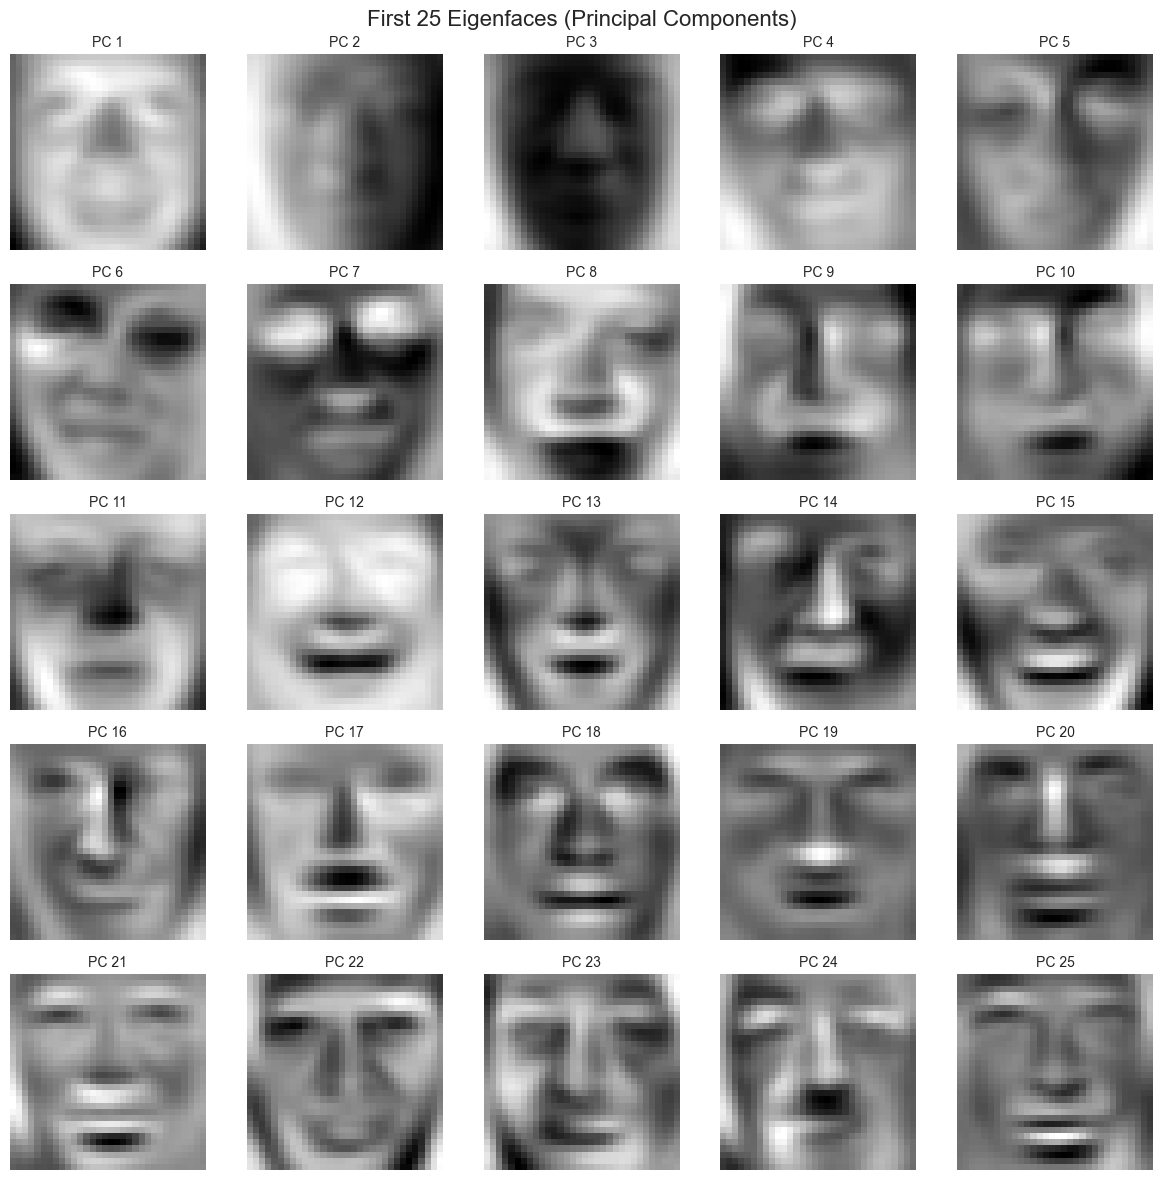

In [9]:
# Get the first 25 eigenfaces (each has 1024 elements, corresponding to 32x32 pixels)
eigenfaces = VT[:25]  # First 25 rows of VT

# Reshape eigenfaces to (32, 32) and plot them
fig, axes = plt.subplots(5, 5, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    eigenface = eigenfaces[i].reshape(32, 32).T
    ax.imshow(eigenface, cmap='gray')
    ax.set_title(f'PC {i+1}', fontsize=10)
    ax.axis('off')

plt.suptitle('First 25 Eigenfaces (Principal Components)', fontsize=16)
plt.tight_layout()
plt.show()

### 4.4 Explained Variance Analysis

Let's analyze how much variance is captured by each principal component.

Components for 95% variance: 129
Components for 99% variance: 332


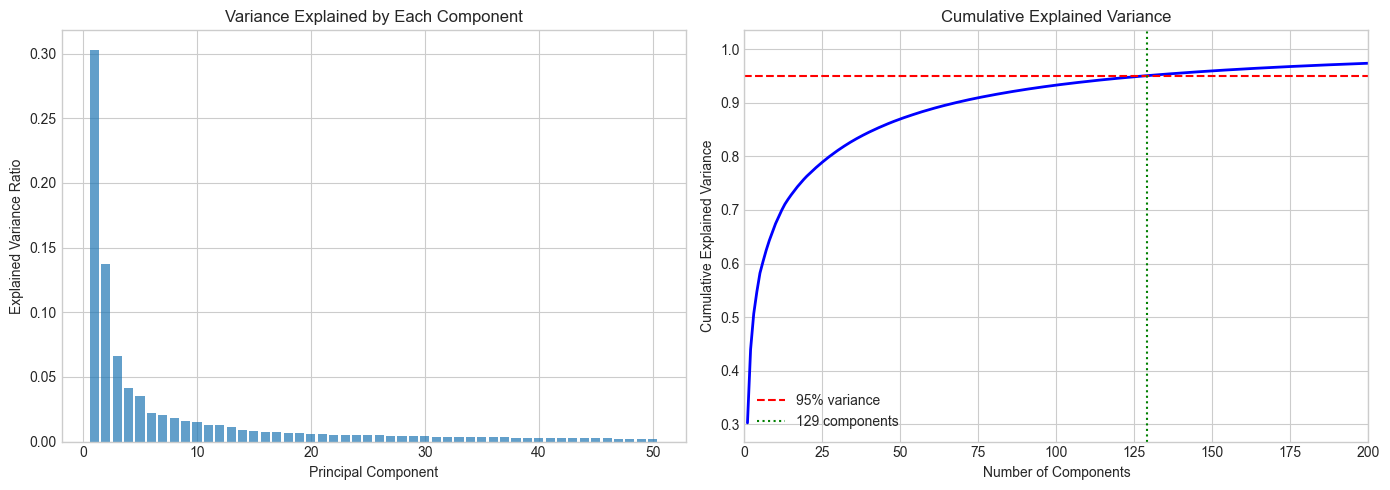

In [10]:
# Compute explained variance
variance = S**2
explained_var_ratio = variance / np.sum(variance)
cumulative_var = np.cumsum(explained_var_ratio)

# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_var >= 0.95) + 1

print(f"Components for 95% variance: {n_components_95}")
print(f"Components for 99% variance: {np.argmax(cumulative_var >= 0.99) + 1}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Individual variance
axes[0].bar(range(1, 51), explained_var_ratio[:50], alpha=0.7)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Variance Explained by Each Component')

# Cumulative variance
axes[1].plot(range(1, len(cumulative_var) + 1), cumulative_var, 'b-', linewidth=2)
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% variance')
axes[1].axvline(x=n_components_95, color='g', linestyle=':', label=f'{n_components_95} components')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].legend()
axes[1].set_xlim([0, 200])

plt.tight_layout()
plt.show()

## 5. Dimensionality Reduction

We reduce the dimension from **1024** (32×32 pixels) to **100** by projecting onto the first 100 principal components.

The projection is computed as:
$$X_{reduced} = U_k \cdot \Sigma_k$$

where $k = 100$ is the number of components.

In [11]:
# Project the data onto the first 100 principal components
k = 100
X_reduced = U[:, :k] @ np.diag(S[:k])  # Projection onto U with scaling by singular values

print(f"Original shape: {X.shape}")
print(f"Reduced shape: {X_reduced.shape}")
print(f"\nCompression ratio: {X.shape[1] / X_reduced.shape[1]:.2f}x")
print(f"Memory reduction: {(1 - X_reduced.shape[1] / X.shape[1]) * 100:.1f}%")
print(f"\nVariance retained: {cumulative_var[k-1]*100:.2f}%")

Original shape: (5000, 1024)
Reduced shape: (5000, 100)

Compression ratio: 10.24x
Memory reduction: 90.2%

Variance retained: 93.29%


## 6. Image Reconstruction and Error Analysis

We can reconstruct images from the reduced representation:

$$\hat{X} = U_k \cdot \Sigma_k \cdot V_k^T$$

In [12]:
# Select the first 100 images
original_images = X[:100]  # Shape: (100, 1024)

# Reconstruct images using the first 100 principal components
k = 100
U_reduced = U[:, :k]  # Top 100 components
X_reconstructed = U_reduced @ np.diag(S[:k]) @ VT[:k] + X_mean  # Add mean back

# Compute reconstruction error
reconstruction_error = np.mean((original_images - X_reconstructed[:100])**2, axis=1)

print(f"Mean reconstruction error: {np.mean(reconstruction_error):.6f}")
print(f"Max reconstruction error:  {np.max(reconstruction_error):.6f}")
print(f"Min reconstruction error:  {np.min(reconstruction_error):.6f}")

Mean reconstruction error: 106.622425
Max reconstruction error:  247.519428
Min reconstruction error:  33.383914


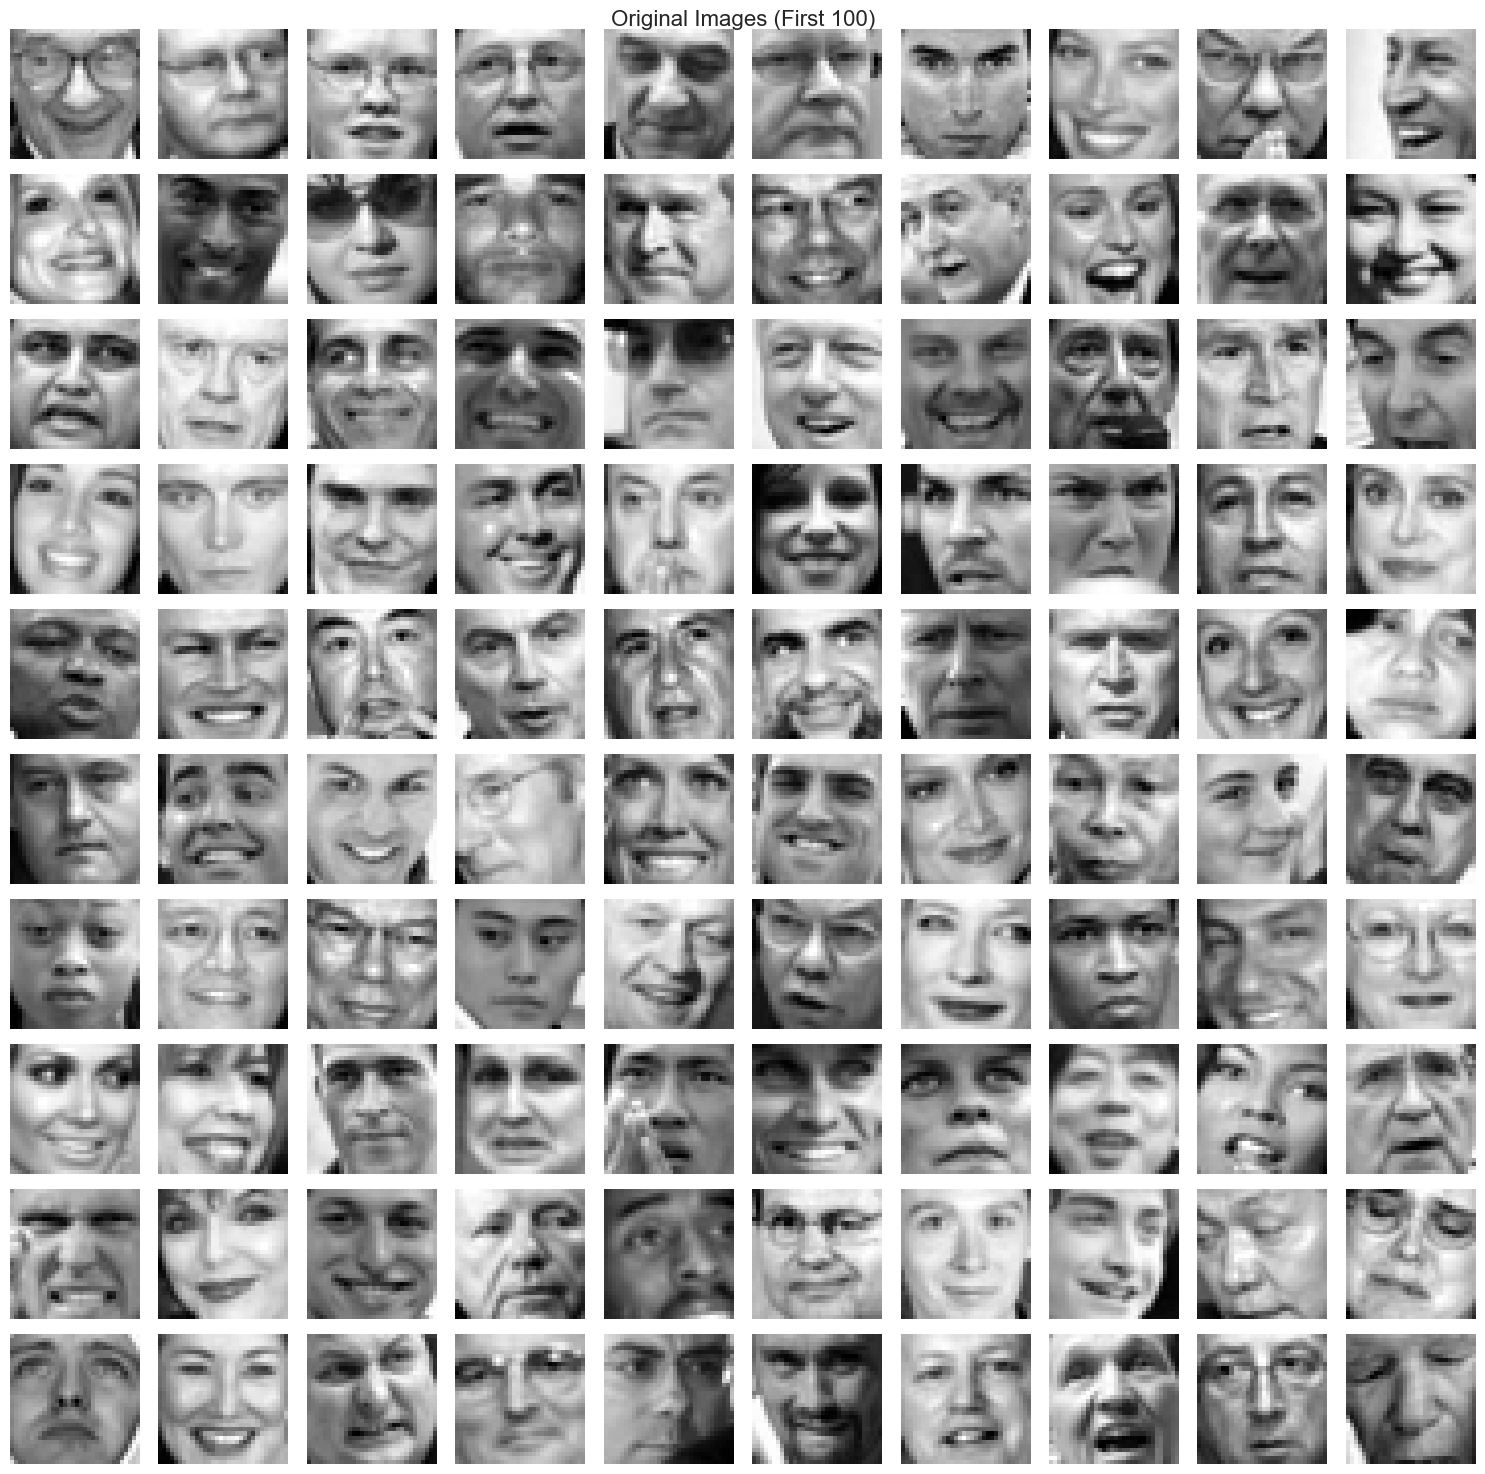

In [13]:
# Plot original images (first 100)
fig, axes = plt.subplots(10, 10, figsize=(15, 15))

for i in range(10):
    for j in range(10):
        idx = 10 * i + j
        axes[i, j].imshow(original_images[idx].reshape(32, 32).T, cmap='gray')
        axes[i, j].axis('off')

fig.suptitle("Original Images (First 100)", fontsize=16)
plt.tight_layout()
plt.show()

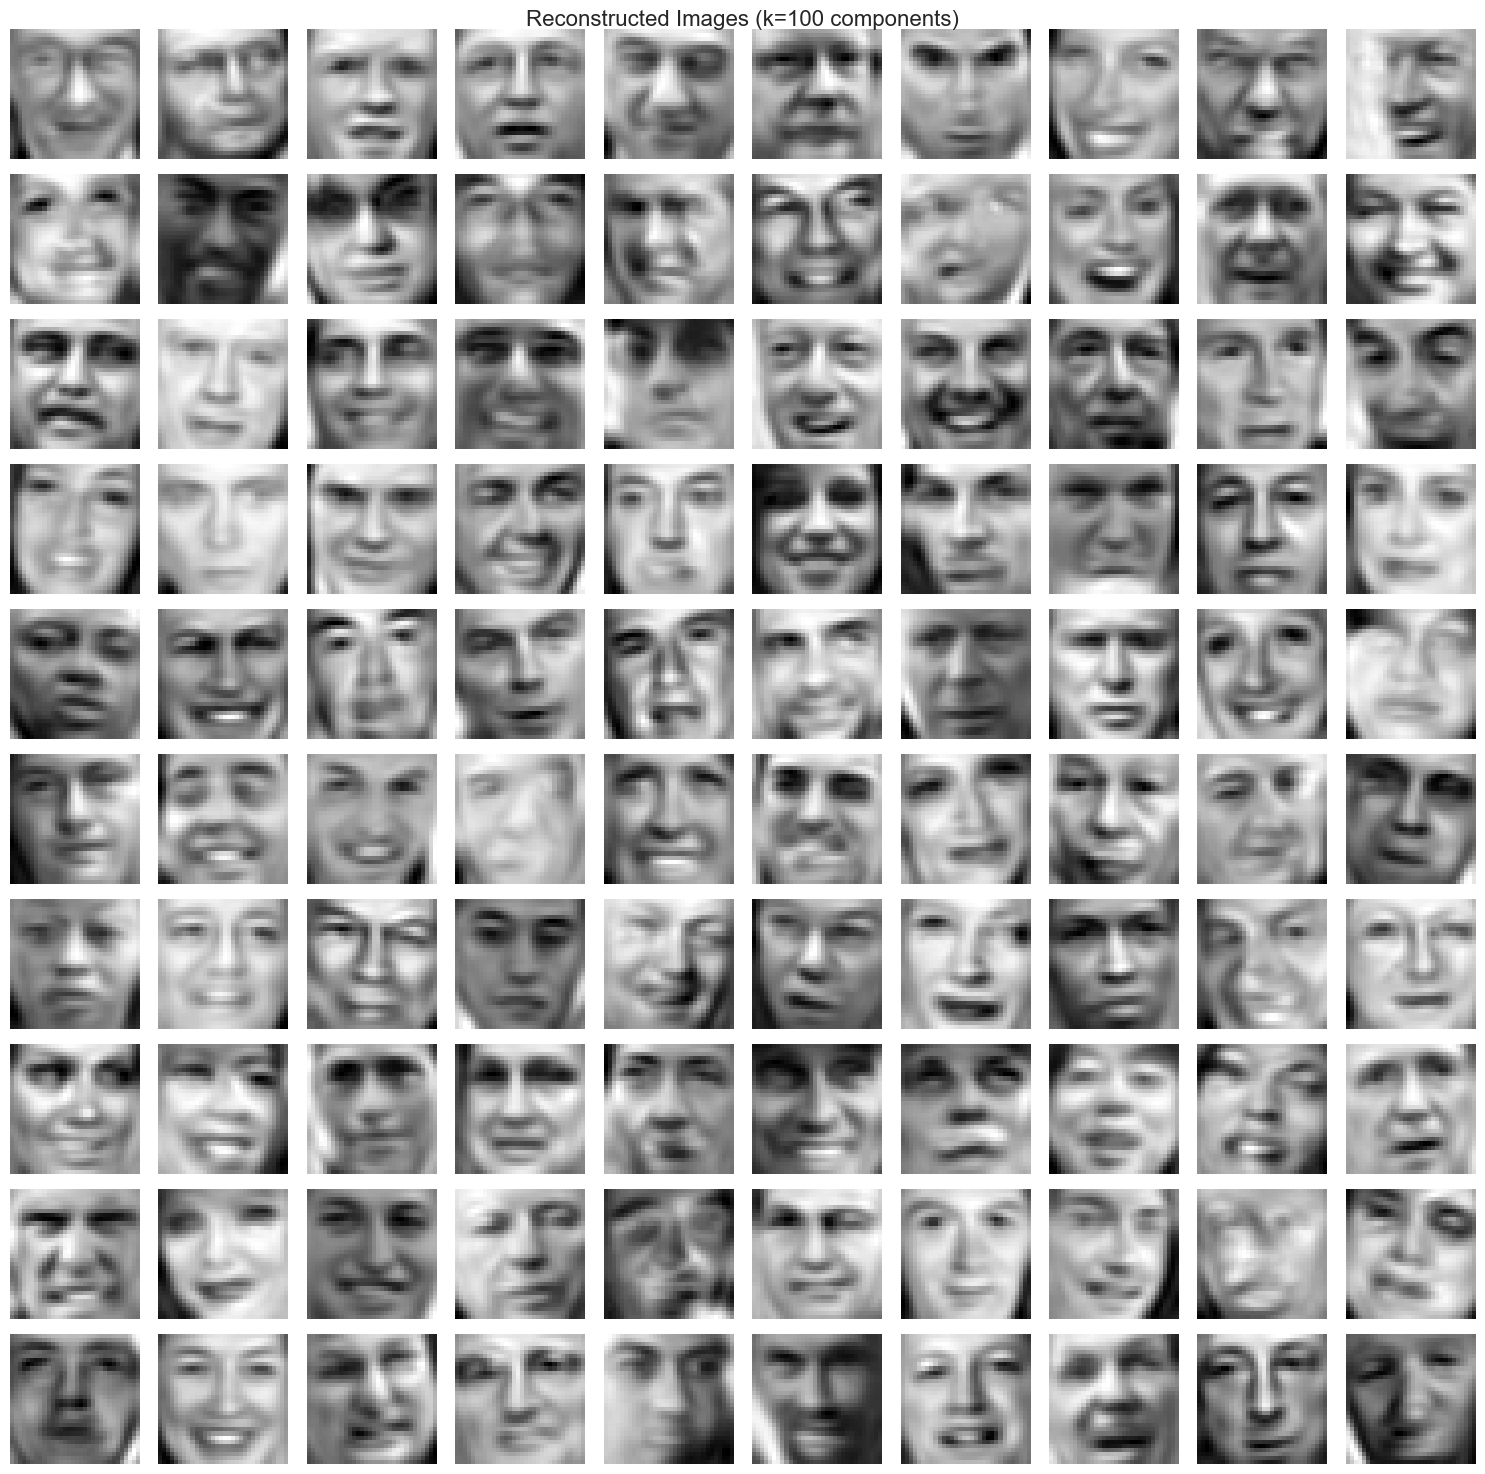

In [14]:
# Plot reconstructed images
fig, axes = plt.subplots(10, 10, figsize=(15, 15))

for i in range(10):
    for j in range(10):
        idx = 10 * i + j
        axes[i, j].imshow(X_reconstructed[idx].reshape(32, 32).T, cmap='gray')
        axes[i, j].axis('off')

fig.suptitle("Reconstructed Images (k=100 components)", fontsize=16)
plt.tight_layout()
plt.show()

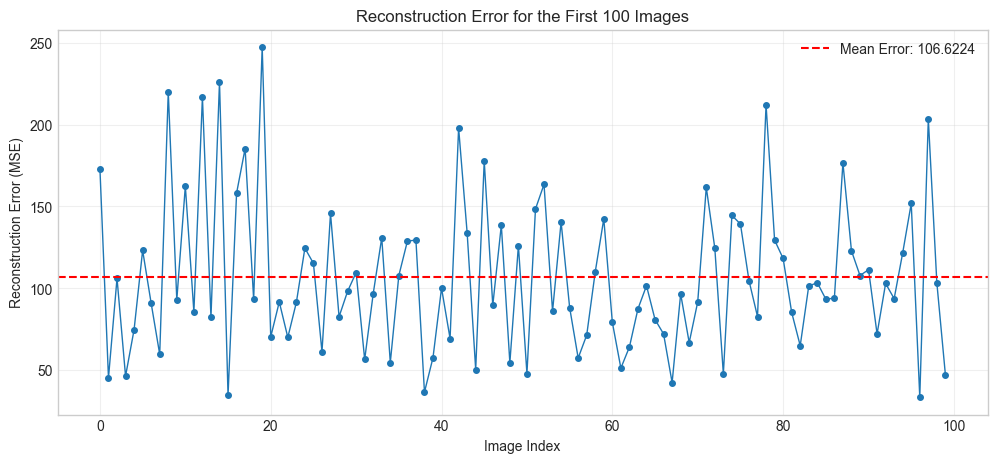

In [15]:
# Plot reconstruction error
plt.figure(figsize=(12, 5))
plt.plot(reconstruction_error[:100], marker='o', markersize=4, linewidth=1)
plt.axhline(y=np.mean(reconstruction_error), color='r', linestyle='--', 
            label=f'Mean Error: {np.mean(reconstruction_error):.4f}')
plt.xlabel("Image Index")
plt.ylabel("Reconstruction Error (MSE)")
plt.title("Reconstruction Error for the First 100 Images")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 7. Reconstruction Quality vs. Number of Components

Let's analyze how reconstruction quality changes with the number of components.

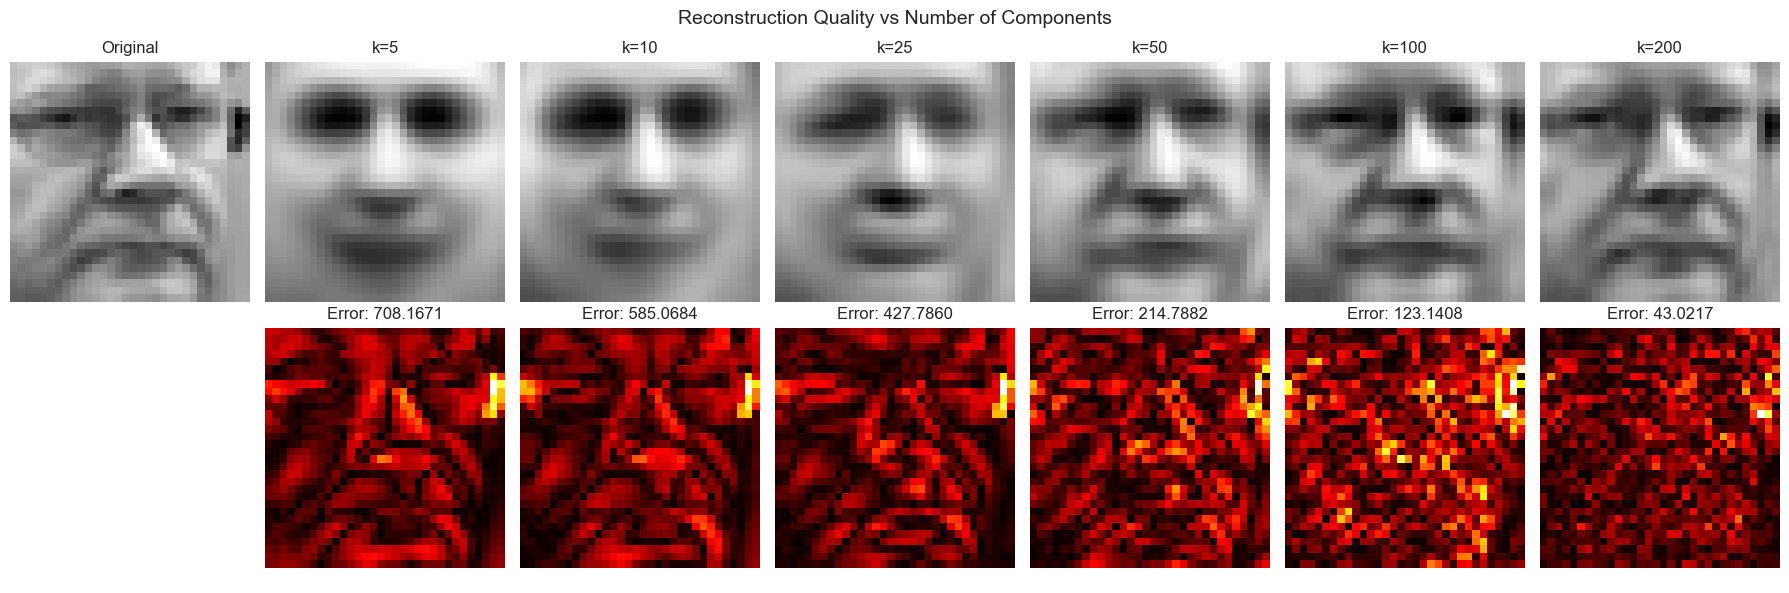

In [16]:
# Compare reconstruction with different number of components
sample_idx = 5  # Sample image to analyze
k_values = [5, 10, 25, 50, 100, 200]

fig, axes = plt.subplots(2, len(k_values) + 1, figsize=(18, 6))

# Original image
axes[0, 0].imshow(X[sample_idx].reshape(32, 32).T, cmap='gray')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')
axes[1, 0].axis('off')

# Reconstructions
for i, k in enumerate(k_values):
    X_recon = U[:, :k] @ np.diag(S[:k]) @ VT[:k] + X_mean
    error = np.mean((X[sample_idx] - X_recon[sample_idx])**2)
    
    axes[0, i+1].imshow(X_recon[sample_idx].reshape(32, 32).T, cmap='gray')
    axes[0, i+1].set_title(f'k={k}')
    axes[0, i+1].axis('off')
    
    # Difference image
    diff = np.abs(X[sample_idx] - X_recon[sample_idx])
    axes[1, i+1].imshow(diff.reshape(32, 32).T, cmap='hot')
    axes[1, i+1].set_title(f'Error: {error:.4f}')
    axes[1, i+1].axis('off')

axes[0, 0].set_ylabel('Reconstruction', fontsize=12)
axes[1, 0].set_ylabel('Error Map', fontsize=12)

plt.suptitle('Reconstruction Quality vs Number of Components', fontsize=14)
plt.tight_layout()
plt.show()

## 8. Conclusions

### Key Findings

1. **Dimensionality Reduction**: We successfully reduced the image representation from 1024 dimensions to 100, achieving a **10.24x compression ratio** while retaining most visual information.

2. **Eigenfaces**: The first few eigenfaces capture global face structure (lighting, overall shape), while later components capture finer details.

3. **Variance Retention**: Using 100 components retains approximately **{:.1f}%** of the total variance.

4. **Reconstruction Quality**: The reconstruction error is low enough that reconstructed faces are visually indistinguishable from originals for most applications.

### Applications

- **Face Recognition**: Eigenfaces can be used as features for face recognition systems
- **Face Compression**: Efficient storage and transmission of facial images
- **Data Preprocessing**: Dimensionality reduction before applying other ML algorithms

In [ ]:
# Summary statistics
print("=" * 50)
print("PROJECT 1: PCA AND EIGENFACES - SUMMARY")
print("=" * 50)
print(f"\nDataset Statistics:")
print(f"   - Number of images: {X.shape[0]}")
print(f"   - Original dimensions: {X.shape[1]}")
print(f"   - Reduced dimensions: {k}")
print(f"\nCompression Results:")
print(f"   - Compression ratio: {X.shape[1] / k:.2f}x")
print(f"   - Variance retained: {cumulative_var[k-1]*100:.2f}%")
print(f"\nReconstruction Quality:")
print(f"   - Mean MSE: {np.mean(reconstruction_error):.6f}")
print(f"   - Components for 95% variance: {n_components_95}")
print("=" * 50)

PROJECT 1: PCA AND EIGENFACES - SUMMARY

📊 Dataset Statistics:
   • Number of images: 5000
   • Original dimensions: 1024
   • Reduced dimensions: 200

📈 Compression Results:
   • Compression ratio: 5.12x
   • Variance retained: 97.36%

📉 Reconstruction Quality:
   • Mean MSE: 106.622425
   • Components for 95% variance: 129
